In [1]:
import os 
import pandas as pd
import pyarrow 
import numpy as np
import seaborn  as sns 
import matplotlib.pyplot as plt

In [63]:
green_sample_path="../data/green_tripdata_2020.parquet"
yellow_sample_path="../data/yellow_tripdata_2020.parquet"
df_green = pd.read_parquet(green_sample_path)
df_yellow = pd.read_parquet(yellow_sample_path)


In [ ]:
df_green.shape, df_yellow.shape

In [9]:
#check missing values
print(df_green.isnull().sum()/len(df_green)*100)


VendorID                   0.000000
lpep_pickup_datetime       0.000000
lpep_dropoff_datetime      0.000000
store_and_fwd_flag        30.459192
RatecodeID                30.459192
PULocationID               0.000000
DOLocationID               0.000000
passenger_count           30.459192
trip_distance              0.000000
fare_amount                0.000000
extra                      0.000000
mta_tax                    0.000000
tip_amount                 0.000000
tolls_amount               0.000000
ehail_fee                100.000000
improvement_surcharge      0.000000
total_amount               0.000000
payment_type              30.459192
trip_type                 30.459480
congestion_surcharge      30.459192
dtype: float64


In [7]:
print(df_yellow.isnull().sum()/len(df_yellow))

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.032860
trip_distance            0.000000
RatecodeID               0.032860
store_and_fwd_flag       0.032860
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.032860
airport_fee              0.999999
dtype: float64


In [64]:
#drop ehail_fee green
df_green=df_green.drop(columns=["ehail_fee"])
#drop airport fee yellow
df_yellow=df_yellow.drop(columns=["airport_fee"])

In [67]:
#get 10000 sample from green 
df_green=df_green.sample(n=10000, random_state=1)
df_yellow=df_yellow.sample(n=10000, random_state=1)


In [68]:
#drop missing values
df_green=df_green.dropna()
df_yellow=df_yellow.dropna()

In [69]:
class MissingData():
    def __init__(self,df):
        self.df=df
    def drop(self):
        self.df=self.df.dropna()
        return self.df
    def fill_mean(self):
        self.df=self.df.fillna(self.df.mean())
        return self.df
    def fill_median(self):
        self.df=self.df.fillna(self.df.median())
        return self.df
    def fill_category(self):
        self.df=self.df.fillna(self.df.mode())
        return self.df
    def fill_zero(self):
        self.df=self.df.fillna(0)
        return self.df
    def fill_constant(self,constant):
        self.df=self.df.fillna(constant)
        return self.df

In [70]:
green_cols = df_green.columns
yellow_cols = df_yellow.columns
#find the common columns
common_cols = set(green_cols).intersection(set(yellow_cols))
print(common_cols)
print(len(common_cols))
diff_green_cols = set(green_cols).difference(set(yellow_cols))
diff_yellow_cols = set(yellow_cols).difference(set(green_cols))
print(diff_green_cols)
print(diff_yellow_cols)


{'VendorID', 'mta_tax', 'congestion_surcharge', 'tip_amount', 'PULocationID', 'fare_amount', 'DOLocationID', 'extra', 'tolls_amount', 'passenger_count', 'RatecodeID', 'trip_distance', 'total_amount', 'store_and_fwd_flag', 'payment_type', 'improvement_surcharge'}
16
{'trip_type', 'lpep_pickup_datetime', 'lpep_dropoff_datetime'}
{'tpep_dropoff_datetime', 'tpep_pickup_datetime'}


In [71]:
#renname lpep_pickup_datetime to pickup_datetime
df_green = df_green.rename(columns={"lpep_pickup_datetime":"pickup_datetime"})
df_yellow = df_yellow.rename(columns={"tpep_pickup_datetime":"pickup_datetime"})
#rename lpep_dropoff_datetime to dropoff_datetime
df_green = df_green.rename(columns={"lpep_dropoff_datetime":"dropoff_datetime"})
df_yellow = df_yellow.rename(columns={"tpep_dropoff_datetime":"dropoff_datetime"})
#rename 
#convert type to string
df_green['pickup_datetime'] = df_green['pickup_datetime'].astype(str)
df_green['dropoff_datetime'] = df_green['dropoff_datetime'].astype(str)

In [85]:
#collapse

# help function
def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff
    # in case test data dont have dropoff_datetime feature
    try:
        df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
        df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
        df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
        df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
        df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    except:
        pass 
    return df_

# get weekday
import calendar


def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_.pickup_datetime).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_



In [86]:
df_green=basic_feature_extract(df_green)
#df_yellow=basic_feature_extract(df_yellow)

In [ ]:
df_green["pickup_week_"]

In [87]:
df_green=get_duration(df_green)
df_green=get_weekday(df_green)

In [ ]:
df_yellow = basic_feature_extract(df_yellow)

In [ ]:
#check type pick up and drop off
print(df_green['pickup_datetime'].dtype)


In [38]:
df_green.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag',
       'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'payment_type',
       'trip_type', 'congestion_surcharge', 'pickup_date', 'pickup_hour',
       'pickup_year', 'pickup_month', 'pickup_weekday', 'dropoff_date',
       'dropoff_hour', 'dropoff_year', 'dropoff_month', 'dropoff_weekday',
       'trip_duration_cal', 'pickup_week_', 'pickup_weekday_', 'id'],
      dtype='object')

In [ ]:
print(df_green.describe())


<Axes: xlabel='pickup_datetime'>

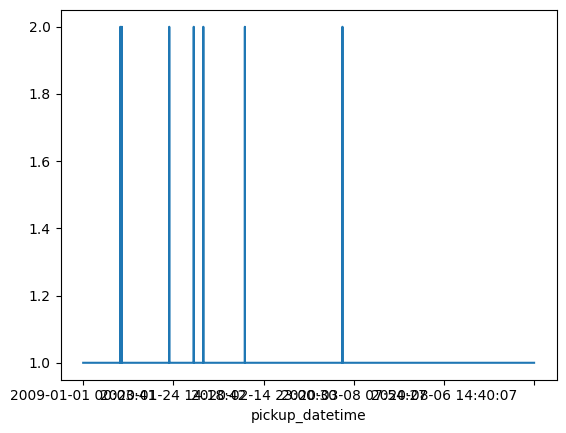

In [76]:
df_green.groupby('pickup_datetime').count()['VendorID'].plot()

In [88]:
#create unique id
df_green['id']=df_green.index

In [28]:
df_green["pickup_date"]
#check type pick up and drop off
print(df_green['pickup_datetime'].dtype)

object


In [32]:
df_yellow=df_yellow.sort_values(by=['pickup_datetime'])
df_green["pickup_datetime"]

21413    2009-01-01 00:03:41
645      2020-01-01 00:33:42
61       2020-01-01 00:51:19
517      2020-01-01 00:54:08
187      2020-01-01 00:59:31
                ...         
45529    2020-12-31 14:21:00
45480    2020-12-31 14:28:41
45970    2020-12-31 18:05:53
45934    2020-12-31 18:07:11
46023    2020-12-31 18:21:57
Name: pickup_datetime, Length: 10000, dtype: object

In [89]:
#sort pickup_date
df_green=df_green.sort_values(by=['pickup_datetime'])

#drop row with index=21413
df_green=df_green.drop(21413)
df_green["pickup_datetime"]

KeyError: '[21413] not found in axis'

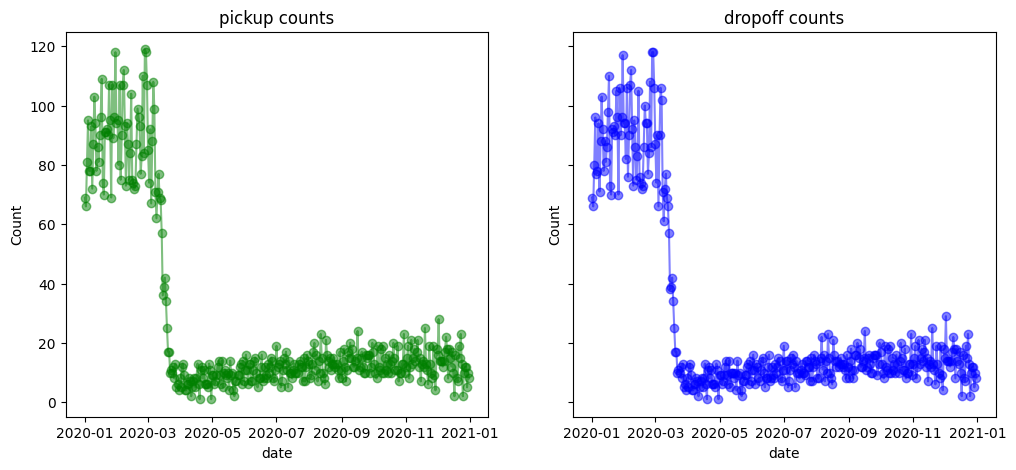

In [90]:
#collapse
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 5)

ax[0].plot(df_green.groupby('pickup_date')["id"].count(), 'go-', alpha=0.5)
ax[1].plot(df_green.groupby('dropoff_date')["id"].count(), 'bo-', alpha=0.5)

ax[0].set(xlabel='date', ylabel='Count',title="pickup counts")
ax[1].set(xlabel='date', ylabel='Count',title="dropoff counts")

plt.show()

<Axes: xlabel='pickup_date'>

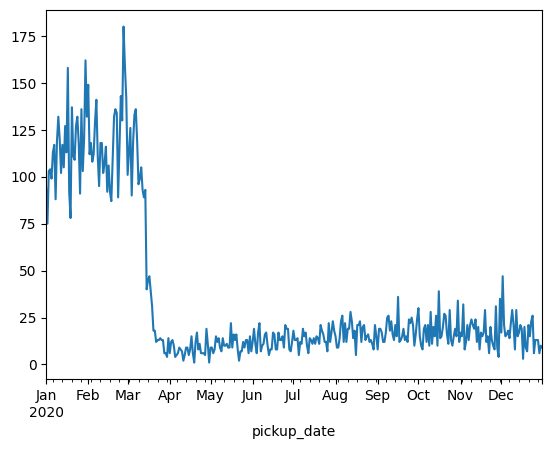

In [81]:
df_green.groupby(['pickup_date']).sum(numeric_only=True)['passenger_count'].plot()

In [91]:
#collapse_show
df_green.store_and_fwd_flag.value_counts()

store_and_fwd_flag
N    9970
Y      29
Name: count, dtype: int64

In [84]:
df_green.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag',
       'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'payment_type',
       'trip_type', 'congestion_surcharge', 'pickup_date', 'pickup_hour',
       'pickup_year', 'pickup_month', 'pickup_weekday', 'dropoff_date',
       'dropoff_hour', 'dropoff_year', 'dropoff_month', 'dropoff_weekday',
       'df_green_cal', 'pickup_week_', 'pickup_weekday_', 'id'],
      dtype='object')

In [92]:
df_green["trip_duration_cal"]
df_green["trip_duration"]=df_green["trip_duration_cal"].dt.total_seconds()

In [53]:
df_green["df_green"]

KeyError: 'df_green'

Text(0.5, 1.0, 'Duration Distribution')

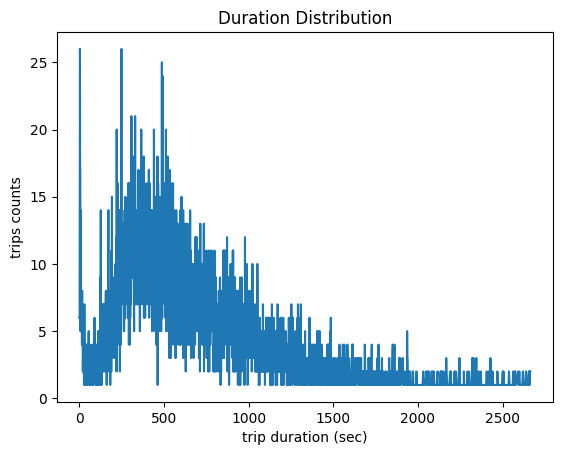

In [130]:
#collapse
# trip duration overall distribution 
# remove outlier by only taking data under .97 quantile

tripduration = df_green[df_green.trip_duration < df_green.trip_duration.quantile(.97)]
tripduration.groupby('trip_duration').count()['id'].plot()

plt.xlabel('trip duration (sec)')
plt.ylabel('trips counts')
plt.title('Duration Distribution')

In [101]:
tripduration['trip_duration'].describe()

count    9699.000000
mean      727.528302
std       510.065441
min         0.000000
25%       362.000000
50%       602.000000
75%       962.000000
max      2664.000000
Name: trip_duration, dtype: float64

In [133]:
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=lambda x: np.mean(x))['trip_duration'].plot(label='mean')

TypeError: Could not convert string '2020-01-01 00:51:192020-01-01 00:54:082020-01-01 00:59:312020-01-02 00:19:162020-01-03 00:53:152020-01-04 00:03:252020-01-04 00:39:022020-01-04 00:40:312020-01-05 00:03:112020-01-05 00:42:112020-01-05 00:57:552020-01-06 00:36:092020-01-06 00:41:522020-01-07 00:09:102020-01-09 00:03:302020-01-09 00:37:482020-01-10 00:03:542020-01-10 00:24:462020-01-11 00:06:002020-01-11 00:06:002020-01-11 00:59:542020-01-12 00:00:282020-01-12 00:49:562020-01-14 00:41:242020-01-14 00:49:362020-01-15 00:38:262020-01-16 00:34:272020-01-16 00:48:082020-01-17 00:09:232020-01-18 00:26:112020-01-18 00:37:042020-01-19 00:11:052020-01-19 00:15:572020-01-19 00:20:002020-01-19 00:36:112020-01-19 00:40:502020-01-20 00:39:282020-01-23 00:07:582020-01-23 00:09:502020-01-23 00:32:532020-01-23 00:34:452020-01-23 00:39:162020-01-24 00:17:062020-01-24 00:55:512020-01-25 00:05:152020-01-25 00:10:042020-01-25 00:10:492020-01-26 00:34:342020-01-26 00:42:292020-01-26 00:55:332020-01-27 00:46:582020-01-28 00:43:112020-01-29 00:15:282020-01-29 00:25:412020-01-30 00:00:402020-01-30 00:43:402020-01-31 00:30:512020-01-31 00:33:312020-01-31 00:53:572020-02-01 00:02:052020-02-01 00:02:212020-02-01 00:02:552020-02-01 00:39:272020-02-02 00:43:212020-02-02 00:45:232020-02-02 00:52:012020-02-03 00:57:132020-02-06 00:04:002020-02-06 00:12:462020-02-06 00:19:082020-02-07 00:20:032020-02-08 00:39:302020-02-09 00:10:052020-02-09 00:13:072020-02-09 00:51:022020-02-10 00:32:552020-02-10 00:40:552020-02-11 00:47:542020-02-13 00:23:102020-02-14 00:08:212020-02-14 00:25:212020-02-15 00:06:442020-02-15 00:16:572020-02-15 00:22:242020-02-15 00:25:242020-02-15 00:25:262020-02-15 00:28:042020-02-15 00:32:092020-02-16 00:11:542020-02-16 00:14:202020-02-16 00:14:242020-02-16 00:15:072020-02-16 00:53:152020-02-16 00:57:162020-02-18 00:04:512020-02-18 00:25:562020-02-20 00:00:292020-02-20 00:36:522020-02-20 00:38:402020-02-22 00:20:482020-02-22 00:55:332020-02-23 00:43:362020-02-23 00:55:552020-02-24 00:37:532020-02-24 00:38:302020-02-25 00:15:482020-02-25 00:21:392020-02-25 00:52:082020-02-26 00:00:042020-02-26 00:07:012020-02-26 00:34:052020-02-27 00:11:062020-02-27 00:22:482020-02-27 00:24:262020-02-28 00:19:532020-02-28 00:43:462020-02-29 00:00:192020-02-29 00:33:362020-02-29 00:44:052020-03-01 00:05:122020-03-01 00:29:182020-03-01 00:38:392020-03-01 00:44:012020-03-02 00:05:022020-03-02 00:53:142020-03-04 00:11:042020-03-04 00:18:592020-03-05 00:27:002020-03-05 00:31:112020-03-05 00:42:212020-03-06 00:43:142020-03-07 00:27:572020-03-07 00:30:012020-03-08 00:21:112020-03-08 00:23:342020-03-08 00:34:192020-03-08 00:45:492020-03-08 00:52:352020-03-09 00:11:232020-03-10 00:03:232020-03-10 00:37:402020-03-11 00:17:022020-03-11 00:18:522020-03-12 00:14:022020-03-12 00:25:522020-03-13 00:38:452020-03-13 00:45:332020-03-14 00:16:142020-03-14 00:36:212020-03-15 00:55:032020-03-17 00:21:062020-03-19 00:02:422020-03-19 00:26:482020-03-22 00:22:492020-03-24 00:53:132020-04-10 00:47:232020-04-11 00:31:162020-04-16 00:21:002020-04-23 00:17:542020-04-26 00:19:312020-04-28 00:06:332020-05-06 00:03:562020-05-09 00:00:022020-05-21 00:57:092020-06-02 00:23:222020-06-06 00:44:392020-06-11 00:41:542020-06-12 00:02:342020-06-14 00:01:342020-06-14 00:36:072020-06-16 00:35:252020-06-21 00:50:032020-06-23 00:09:162020-06-25 00:27:472020-06-26 00:45:002020-06-28 00:31:502020-06-30 00:40:192020-07-01 00:05:182020-07-03 00:32:302020-07-04 00:32:442020-07-25 00:11:562020-07-29 00:50:572020-08-08 00:08:532020-08-21 00:12:002020-08-30 00:49:232020-09-05 00:08:012020-09-09 00:30:522020-09-16 00:06:242020-09-19 00:35:292020-09-22 00:09:032020-09-23 00:56:012020-09-25 00:30:222020-09-27 00:01:082020-09-30 00:45:042020-10-25 00:00:492020-10-25 00:01:342020-10-29 00:30:262020-10-30 00:20:162020-11-06 00:12:442020-11-16 00:12:482020-11-21 00:45:272020-11-26 00:21:312020-11-27 00:21:542020-11-30 00:44:552020-12-11 00:11:152020-12-13 00:11:502020-12-19 00:56:322020-12-23 00:27:552020-12-28 00:55:08' to numeric

In [128]:
tripduration

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,df_green_cal,pickup_week_,pickup_weekday_,id,trip_duration_cal,trip_duration
61,2,2020-01-01 00:51:19,2020-01-01 01:00:21,N,1.0,95,131,1.0,3.52,12.0,...,01,2020,01,2,0 days 00:09:02,2,Wednesday,61,0 days 00:09:02,542.0
517,2,2020-01-01 00:54:08,2020-01-01 00:55:33,N,1.0,75,75,1.0,0.34,3.5,...,00,2020,01,2,0 days 00:01:25,2,Wednesday,517,0 days 00:01:25,85.0
187,2,2020-01-01 00:59:31,2020-01-01 01:05:31,N,1.0,75,75,1.0,0.98,6.0,...,01,2020,01,2,0 days 00:06:00,2,Wednesday,187,0 days 00:06:00,360.0
930,2,2020-01-01 01:10:00,2020-01-01 01:23:11,N,1.0,256,148,1.0,2.44,11.5,...,01,2020,01,2,0 days 00:13:11,2,Wednesday,930,0 days 00:13:11,791.0
1350,2,2020-01-01 01:16:01,2020-01-01 01:21:07,N,1.0,129,129,1.0,0.98,6.0,...,01,2020,01,2,0 days 00:05:06,2,Wednesday,1350,0 days 00:05:06,306.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45272,2,2020-12-31 11:59:40,2020-12-31 12:05:29,N,1.0,33,40,1.0,1.27,6.0,...,12,2020,12,3,0 days 00:05:49,3,Thursday,45272,0 days 00:05:49,349.0
45480,2,2020-12-31 14:28:41,2020-12-31 14:53:10,N,1.0,75,243,1.0,5.03,19.5,...,14,2020,12,3,0 days 00:24:29,3,Thursday,45480,0 days 00:24:29,1469.0
45970,2,2020-12-31 18:05:53,2020-12-31 18:11:39,N,1.0,42,116,1.0,1.10,6.0,...,18,2020,12,3,0 days 00:05:46,3,Thursday,45970,0 days 00:05:46,346.0
45934,2,2020-12-31 18:07:11,2020-12-31 18:15:18,N,1.0,74,75,1.0,1.43,7.5,...,18,2020,12,3,0 days 00:08:07,3,Thursday,45934,0 days 00:08:07,487.0


In [106]:
#reset index
df_green=df_green.reset_index(drop=True)

In [108]:
df_green

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,df_green_cal,pickup_week_,pickup_weekday_,id,trip_duration_cal,trip_duration
0,2,2020-01-01 00:33:42,2020-01-01 01:30:10,N,1.0,223,170,1.0,6.20,36.0,...,01,2020,01,2,0 days 00:56:28,2,Wednesday,645,0 days 00:56:28,3388.0
1,2,2020-01-01 00:51:19,2020-01-01 01:00:21,N,1.0,95,131,1.0,3.52,12.0,...,01,2020,01,2,0 days 00:09:02,2,Wednesday,61,0 days 00:09:02,542.0
2,2,2020-01-01 00:54:08,2020-01-01 00:55:33,N,1.0,75,75,1.0,0.34,3.5,...,00,2020,01,2,0 days 00:01:25,2,Wednesday,517,0 days 00:01:25,85.0
3,2,2020-01-01 00:59:31,2020-01-01 01:05:31,N,1.0,75,75,1.0,0.98,6.0,...,01,2020,01,2,0 days 00:06:00,2,Wednesday,187,0 days 00:06:00,360.0
4,2,2020-01-01 01:10:00,2020-01-01 01:23:11,N,1.0,256,148,1.0,2.44,11.5,...,01,2020,01,2,0 days 00:13:11,2,Wednesday,930,0 days 00:13:11,791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2,2020-12-31 14:21:00,2020-12-31 15:06:52,N,1.0,97,215,1.0,18.53,56.5,...,15,2020,12,3,0 days 00:45:52,3,Thursday,45529,0 days 00:45:52,2752.0
9995,2,2020-12-31 14:28:41,2020-12-31 14:53:10,N,1.0,75,243,1.0,5.03,19.5,...,14,2020,12,3,0 days 00:24:29,3,Thursday,45480,0 days 00:24:29,1469.0
9996,2,2020-12-31 18:05:53,2020-12-31 18:11:39,N,1.0,42,116,1.0,1.10,6.0,...,18,2020,12,3,0 days 00:05:46,3,Thursday,45970,0 days 00:05:46,346.0
9997,2,2020-12-31 18:07:11,2020-12-31 18:15:18,N,1.0,74,75,1.0,1.43,7.5,...,18,2020,12,3,0 days 00:08:07,3,Thursday,45934,0 days 00:08:07,487.0


In [122]:
#check data type
df_green.pickup_datetime.dtype
# #convert to object
# df_green['pickup_hour'] = df_green['pickup_hour'].astype(str)

dtype('O')

In [127]:
df_green['pickup_hour'].dtype

dtype('O')

In [129]:
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=lambda x: np.mean(x))["trip_duration"].plot(label='mean')

TypeError: Could not convert string '2020-01-01 00:51:192020-01-01 00:54:082020-01-01 00:59:312020-01-02 00:19:162020-01-03 00:53:152020-01-04 00:03:252020-01-04 00:39:022020-01-04 00:40:312020-01-05 00:03:112020-01-05 00:42:112020-01-05 00:57:552020-01-06 00:36:092020-01-06 00:41:522020-01-07 00:09:102020-01-09 00:03:302020-01-09 00:37:482020-01-10 00:03:542020-01-10 00:24:462020-01-11 00:06:002020-01-11 00:06:002020-01-11 00:59:542020-01-12 00:00:282020-01-12 00:49:562020-01-14 00:41:242020-01-14 00:49:362020-01-15 00:38:262020-01-16 00:34:272020-01-16 00:48:082020-01-17 00:09:232020-01-18 00:26:112020-01-18 00:37:042020-01-19 00:11:052020-01-19 00:15:572020-01-19 00:20:002020-01-19 00:36:112020-01-19 00:40:502020-01-20 00:39:282020-01-23 00:07:582020-01-23 00:09:502020-01-23 00:32:532020-01-23 00:34:452020-01-23 00:39:162020-01-24 00:17:062020-01-24 00:55:512020-01-25 00:05:152020-01-25 00:10:042020-01-25 00:10:492020-01-26 00:34:342020-01-26 00:42:292020-01-26 00:55:332020-01-27 00:46:582020-01-28 00:43:112020-01-29 00:15:282020-01-29 00:25:412020-01-30 00:00:402020-01-30 00:43:402020-01-31 00:30:512020-01-31 00:33:312020-01-31 00:53:572020-02-01 00:02:052020-02-01 00:02:212020-02-01 00:02:552020-02-01 00:39:272020-02-02 00:43:212020-02-02 00:45:232020-02-02 00:52:012020-02-03 00:57:132020-02-06 00:04:002020-02-06 00:12:462020-02-06 00:19:082020-02-07 00:20:032020-02-08 00:39:302020-02-09 00:10:052020-02-09 00:13:072020-02-09 00:51:022020-02-10 00:32:552020-02-10 00:40:552020-02-11 00:47:542020-02-13 00:23:102020-02-14 00:08:212020-02-14 00:25:212020-02-15 00:06:442020-02-15 00:16:572020-02-15 00:22:242020-02-15 00:25:242020-02-15 00:25:262020-02-15 00:28:042020-02-15 00:32:092020-02-16 00:11:542020-02-16 00:14:202020-02-16 00:14:242020-02-16 00:15:072020-02-16 00:53:152020-02-16 00:57:162020-02-18 00:04:512020-02-18 00:25:562020-02-20 00:00:292020-02-20 00:36:522020-02-20 00:38:402020-02-22 00:20:482020-02-22 00:55:332020-02-23 00:43:362020-02-23 00:55:552020-02-24 00:37:532020-02-24 00:38:302020-02-25 00:15:482020-02-25 00:21:392020-02-25 00:52:082020-02-26 00:00:042020-02-26 00:07:012020-02-26 00:34:052020-02-27 00:11:062020-02-27 00:22:482020-02-27 00:24:262020-02-28 00:19:532020-02-28 00:43:462020-02-29 00:00:192020-02-29 00:33:362020-02-29 00:44:052020-03-01 00:05:122020-03-01 00:29:182020-03-01 00:38:392020-03-01 00:44:012020-03-02 00:05:022020-03-02 00:53:142020-03-04 00:11:042020-03-04 00:18:592020-03-05 00:27:002020-03-05 00:31:112020-03-05 00:42:212020-03-06 00:43:142020-03-07 00:27:572020-03-07 00:30:012020-03-08 00:21:112020-03-08 00:23:342020-03-08 00:34:192020-03-08 00:45:492020-03-08 00:52:352020-03-09 00:11:232020-03-10 00:03:232020-03-10 00:37:402020-03-11 00:17:022020-03-11 00:18:522020-03-12 00:14:022020-03-12 00:25:522020-03-13 00:38:452020-03-13 00:45:332020-03-14 00:16:142020-03-14 00:36:212020-03-15 00:55:032020-03-17 00:21:062020-03-19 00:02:422020-03-19 00:26:482020-03-22 00:22:492020-03-24 00:53:132020-04-10 00:47:232020-04-11 00:31:162020-04-16 00:21:002020-04-23 00:17:542020-04-26 00:19:312020-04-28 00:06:332020-05-06 00:03:562020-05-09 00:00:022020-05-21 00:57:092020-06-02 00:23:222020-06-06 00:44:392020-06-11 00:41:542020-06-12 00:02:342020-06-14 00:01:342020-06-14 00:36:072020-06-16 00:35:252020-06-21 00:50:032020-06-23 00:09:162020-06-25 00:27:472020-06-26 00:45:002020-06-28 00:31:502020-06-30 00:40:192020-07-01 00:05:182020-07-03 00:32:302020-07-04 00:32:442020-07-25 00:11:562020-07-29 00:50:572020-08-08 00:08:532020-08-21 00:12:002020-08-30 00:49:232020-09-05 00:08:012020-09-09 00:30:522020-09-16 00:06:242020-09-19 00:35:292020-09-22 00:09:032020-09-23 00:56:012020-09-25 00:30:222020-09-27 00:01:082020-09-30 00:45:042020-10-25 00:00:492020-10-25 00:01:342020-10-29 00:30:262020-10-30 00:20:162020-11-06 00:12:442020-11-16 00:12:482020-11-21 00:45:272020-11-26 00:21:312020-11-27 00:21:542020-11-30 00:44:552020-12-11 00:11:152020-12-13 00:11:502020-12-19 00:56:322020-12-23 00:27:552020-12-28 00:55:08' to numeric

In [136]:
#convert trip duration to object
tripduration['trip_duration'] = tripduration['trip_duration'].astype(str)


/tmp/ipykernel_8965/1733707596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripduration['trip_duration'] = tripduration['trip_duration'].astype(str)


In [141]:
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc="mean")['trip_duration'].plot(label='mean')

TypeError: agg function failed [how->mean,dtype->object]

In [139]:
#collapse

# pivot table
# http://pbpython.com/pandas-pivot-table-explained.html

tripduration = df_green[df_green.trip_duration < df_green.trip_duration.quantile(.97)]


pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc="mean")['trip_duration'].plot(label='mean')
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.median)['trip_duration'].plot(label='median')
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.std)['trip_duration'].plot(label='std')

plt.legend(loc=0)
plt.xlabel('Pick up Hour (0-23)')
plt.ylabel('orders counts ')
plt.title('Orders VS Pickup hour')
plt.show()

TypeError: agg function failed [how->mean,dtype->object]

Text(0, 0.5, 'mean(trip_duration)')

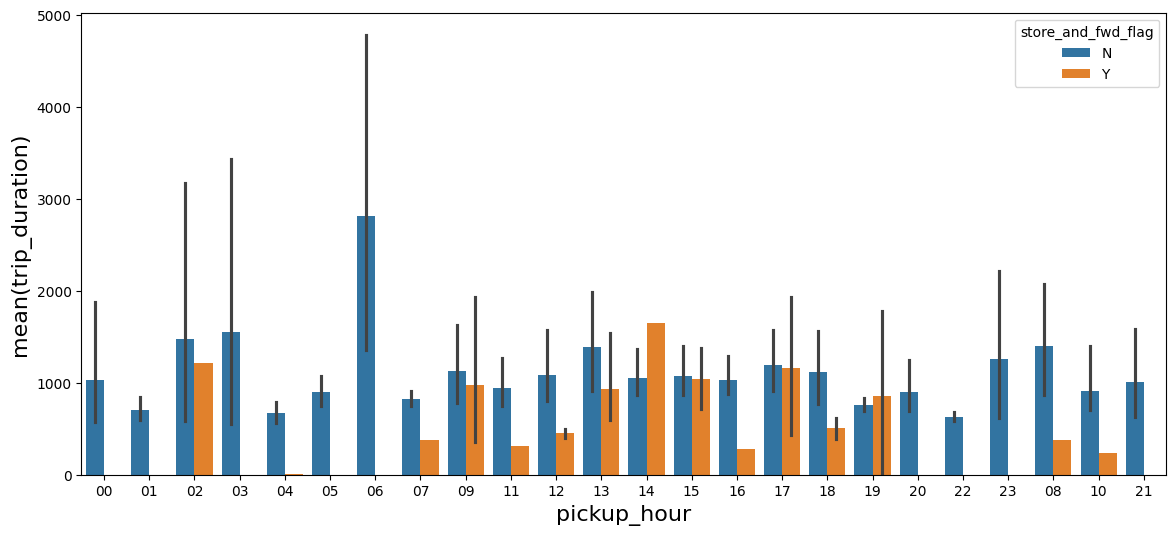

In [143]:
#collapse

# plots trip duration on store_and_fwd_flag 
# (send back data to vendor server directly or save in taxi then upload because internet issues)

plt.figure(figsize=(14,6))
sns.barplot(x='pickup_hour',y='trip_duration',data=df_green,hue='store_and_fwd_flag')
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)


Text(0, 0.5, 'mean(trip_duration)')

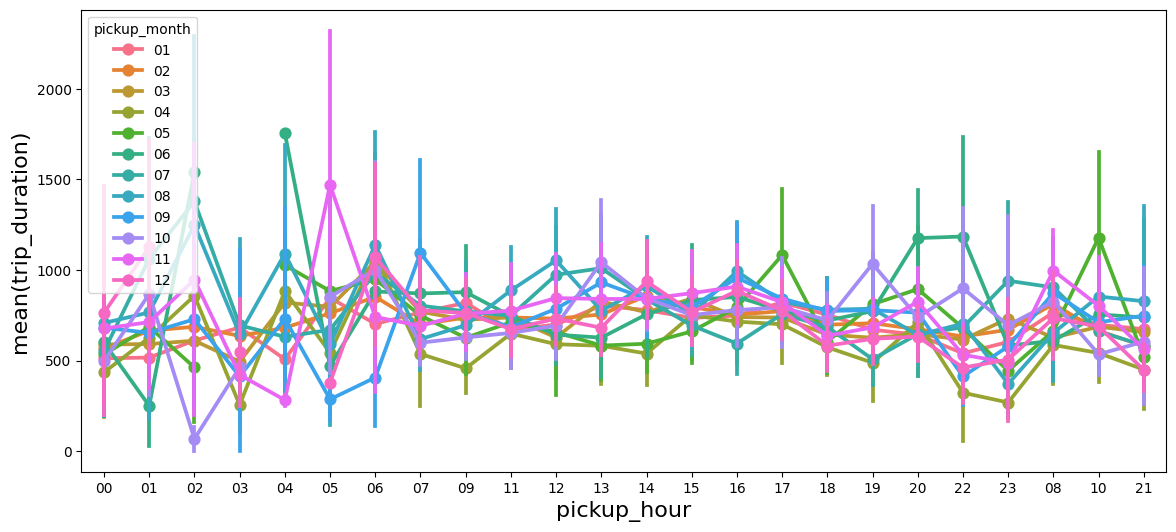

In [144]:
#collapse
# duration VS. pickup hour in given months 

plt.figure(figsize=(14,6))
sns.pointplot(x='pickup_hour',y='trip_duration',data=tripduration,hue='pickup_month')
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)

Text(0, 0.5, 'mean(trip_duration)')

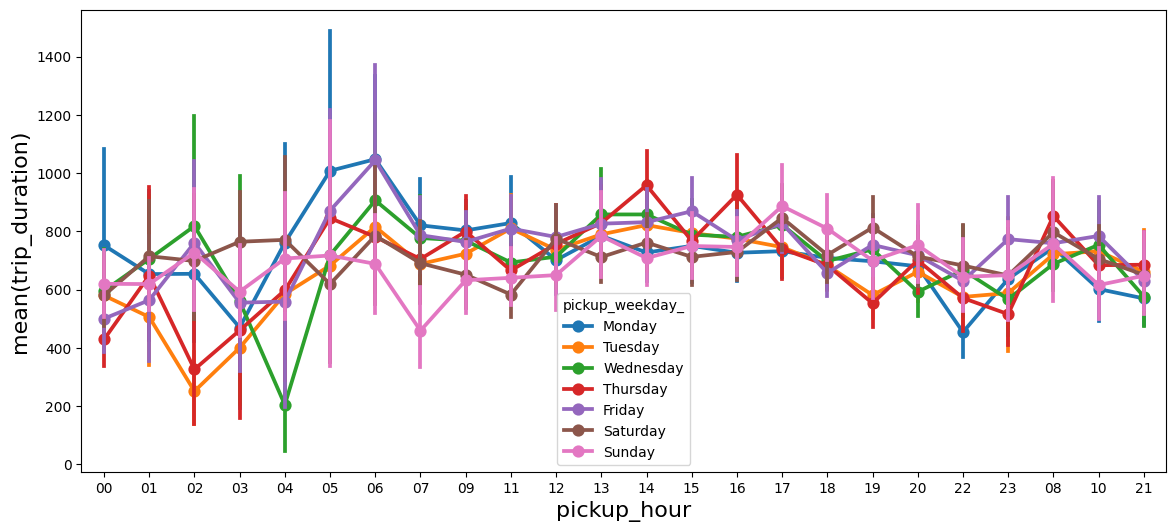

In [145]:
#collapse
# duration VS. pickup hour in weekdays 


plt.figure(figsize=(14,6))
sns.pointplot(x='pickup_hour',y='trip_duration',data=tripduration,hue='pickup_weekday_',hue_order=list(calendar.day_name))
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)